# Functional analysis of re-calibrated (simplified) circuits

<u>Related ticket</u>: [ACCS-65](https://bbpteam.epfl.ch/project/issues/browse/ACCS-65)


In [1]:
import sys
sys.path.append('/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/cortex_etl')
import cortex_etl as c_etl
import matplotlib
import matplotlib.pyplot as plt
matplotlib.set_loglevel("error")
import numpy as np
import os
import pandas as pd
import tqdm
import yaml

In [2]:
figs_paths = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/calibration_v2/figs'
if not os.path.exists(figs_paths):
    os.makedirs(figs_paths)

In [13]:
ITER_NAMES = {_k: _v for _k, _v in enumerate(['first', 'second', 'third', 'fourth', 'fifth'])}

config_path = '/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/sscx-workflows/simplified_connectome_models/calibration/notebooks'
calib_path = '/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/sscx-workflows/simplified_connectome_models/calibration/workflows'

In [38]:
def upper(txt, first_n=None):
    if first_n is None:
        return txt.upper()
    else:
        return txt[:first_n].upper() + txt[first_n:]

In [169]:
# Load .parquet files from re-calibration
order_list = [0, 1, 2, 3, 4, 5]  # 0...orig
desired_connected_proportion_of_invivo_frs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_iter = 5  # 0..first, 1..second, ...

calib_dfs = {}
for _pfr in desired_connected_proportion_of_invivo_frs:
    calib_dfs[_pfr] = []
    neuron_classes = None
    for iter_idx in range(num_iter):

        config_files = [f'connectome_rewiring_calibration_{_ord}-{iter_idx}.yaml' for _ord in order_list]
        calib_files = [f'order{_ord}_connection_data_from_{ITER_NAMES[iter_idx]}_iteration.parquet' for _ord in order_list]

        dfs_ord = []
        for _cfg, _cal in zip(config_files, calib_files):
            with open(os.path.join(config_path, _cfg), 'r') as f:
                cfg_dict = yaml.safe_load(f)
            vivo_frs = cfg_dict['analysis']['hex0_spikes']['custom']['vivo_frs']  # Load in-vivo reference firing rates from config

            df = pd.read_parquet(os.path.join(calib_path, _cal))
            df = df.loc[df['desired_connected_proportion_of_invivo_frs'] == _pfr]
            df['vivo_frs'] = [vivo_frs[_cl] for _cl in df['neuron_class']]  # Add in-vivo firing rates to data frame

            if neuron_classes is None:
                neuron_classes = df['neuron_class'].tolist()
            else:
                assert np.array_equal(neuron_classes, df['neuron_class'].tolist()), 'ERROR: Neuron class mismatch!'

            dfs_ord.append(df)
        calib_dfs[_pfr].append(dfs_ord)

In [128]:
df.columns

Index(['circuit_id', 'neuron_class', 'window', 'mean_of_mean_spike_counts',
       'mean_of_mean_firing_rates_per_second',
       'std_of_mean_firing_rates_per_second', 'ca',
       'desired_connected_proportion_of_invivo_frs', 'depol_stdev_mean_ratio',
       'ei_corr_r_out_of_range', 'neuron_group_gt_threshold_fr', 'bursting',
       'bursting_or_fr_gt_threshold',
       'bursting_or_fr_gt_threshold_or_ei_corr_r_out_of_range',
       'desired_connected_fr', 'desired_unconnected_fr', 'depol_mean',
       'depol_sd', 'connection_fr_increase', 'connection_fr_error',
       'connection_vs_unconn_proportion', 'recorded_proportion_of_in_vivo_FR',
       'true_mean_conductance', 'vivo_frs'],
      dtype='object')

In [129]:
ORDER_COLORS = ['black', 'tab:purple', 'tab:blue', 'tab:green', 'tab:orange', 'tab:red']

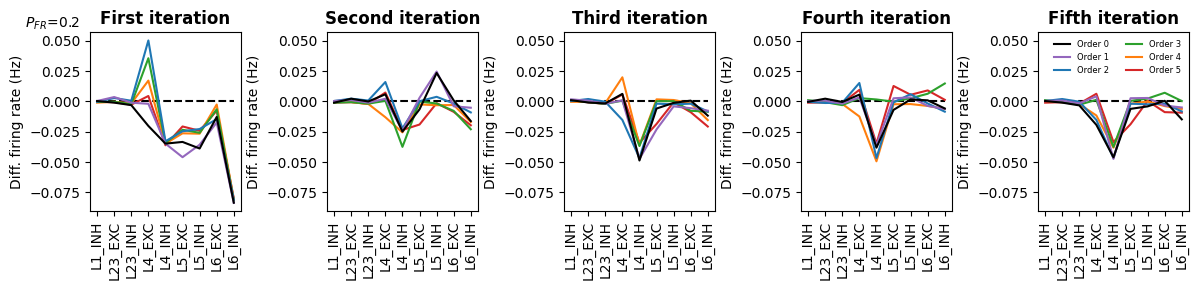

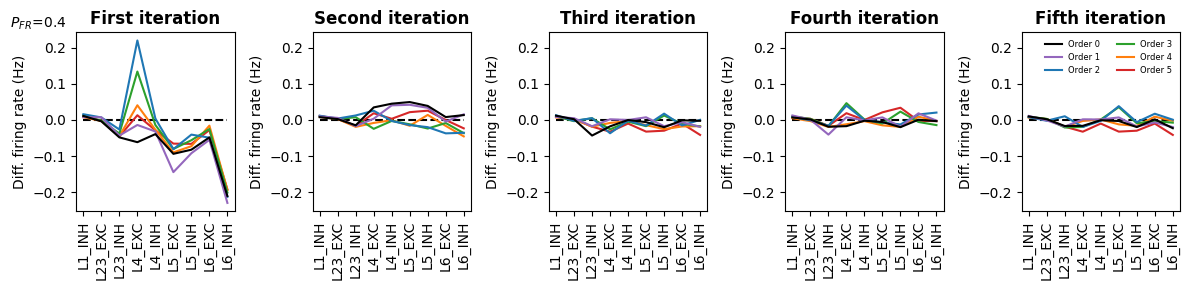

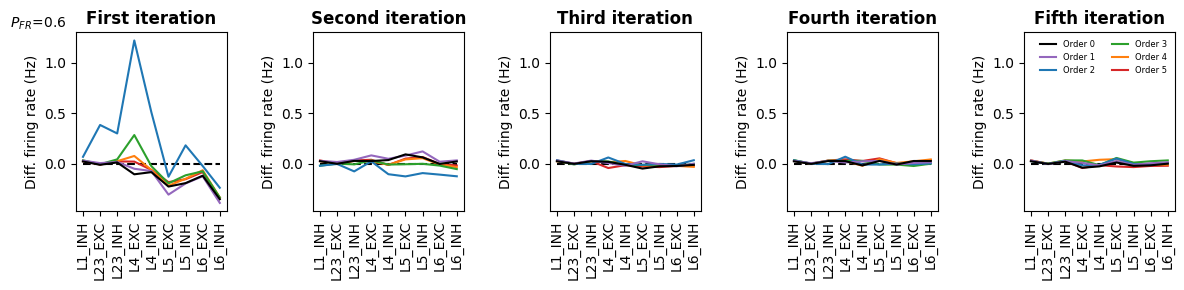

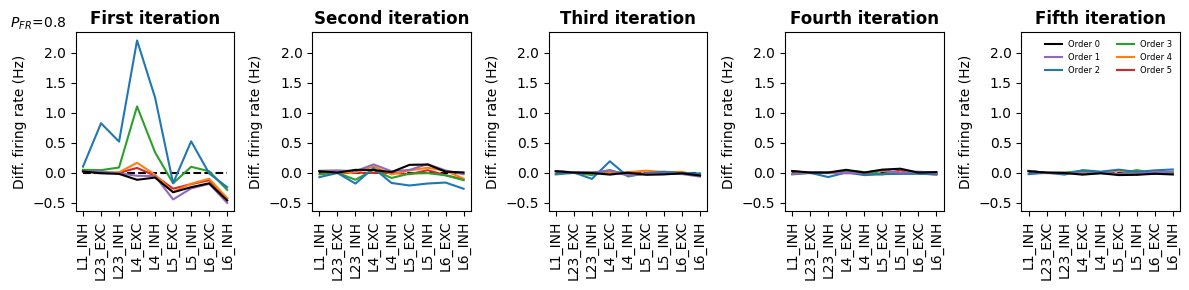

In [185]:
# for pfr_sel in desired_connected_proportion_of_invivo_frs:
for pfr_sel in [0.2, 0.4, 0.6, 0.8]:
    plt.figure(figsize=(12, 3))
    y_lim = None
    for iter_idx in range(num_iter):
        plt.subplot(1, num_iter, iter_idx + 1)
        for _ord, _df in zip(order_list, calib_dfs[pfr_sel][iter_idx]):
            plt.plot(range(len(neuron_classes)), _df['mean_of_mean_firing_rates_per_second'].values - _df['desired_connected_fr'].values, color=ORDER_COLORS[_ord], label=f'Order {_ord}', zorder=-_ord)
            # plt.plot(range(len(neuron_classes)), _df['mean_of_mean_firing_rates_per_second'].values - calib_dfs[pfr_sel][iter_idx][0]['mean_of_mean_firing_rates_per_second'].values, color=ORDER_COLORS[_ord], label=f'Order {_ord}', zorder=-_ord)
            # lw=0.5 + 0.5 * iter_idx, alpha=0.1 + iter_idx * 0.9 / (num_iter - 1)
            # plt.plot(range(len(neuron_classes)), _df['desired_connected_fr'].values, '+k')
        plt.plot(range(len(neuron_classes)), np.zeros(len(neuron_classes)), 'k--', zorder=-100)
        plt.xticks(range(len(neuron_classes)), neuron_classes, rotation=90)
        plt.ylabel('Diff. firing rate (Hz)')
        plt.title(f'{upper(ITER_NAMES[iter_idx], 1)} iteration', fontweight='bold')
        if y_lim is None:
            y_lim = plt.ylim()
        else:
            plt.ylim(y_lim)
        if iter_idx == 0:
            plt.text(np.min(plt.xlim()), np.max(plt.ylim()), f'$P_F$$_R$={pfr_sel}   ', ha='right', va='bottom')
    plt.legend(frameon=False, ncols=2, fontsize=6)
    plt.tight_layout()
    plt.show()

In [122]:
# _df['desired_connected_fr'] == _df['desired_connected_proportion_of_invivo_frs'].values * _df['vivo_frs'].values

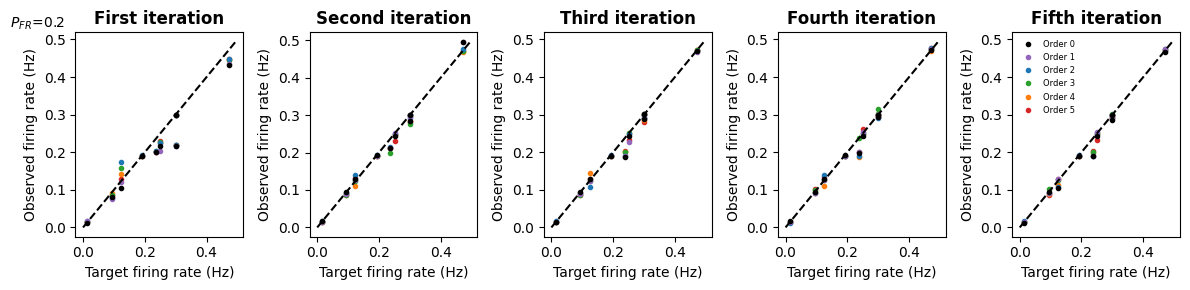

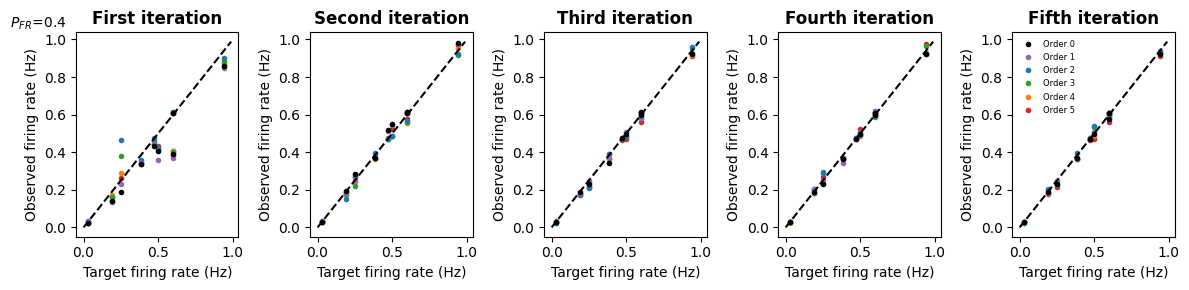

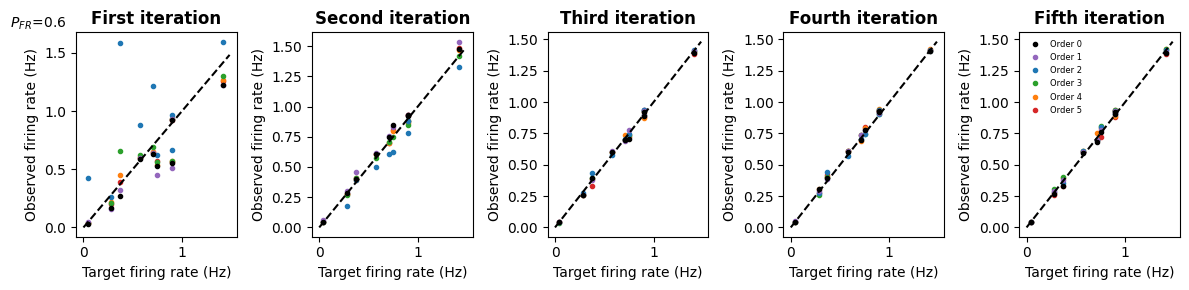

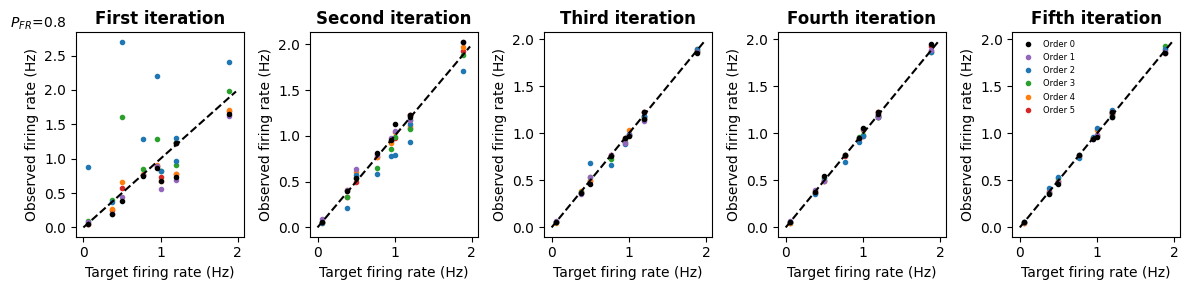

In [190]:
# for pfr_sel in desired_connected_proportion_of_invivo_frs:
for pfr_sel in [0.2, 0.4, 0.6, 0.8]:
    plt.figure(figsize=(12, 3))
    for iter_idx in range(num_iter):
        plt.subplot(1, num_iter, iter_idx + 1)
        for _ord, _df in zip(order_list, calib_dfs[pfr_sel][iter_idx]):
            plt.plot(_df['desired_connected_fr'].values, _df['mean_of_mean_firing_rates_per_second'].values, '.', color=ORDER_COLORS[_ord], label=f'Order {_ord}', zorder=-_ord)
        plt.plot(*([[0, np.max(plt.xlim())]] * 2), 'k--', zorder=0)
        plt.xlabel('Target firing rate (Hz)')
        plt.ylabel('Observed firing rate (Hz)')
        plt.title(f'{upper(ITER_NAMES[iter_idx], 1)} iteration', fontweight='bold')
        if iter_idx == 0:
            plt.text(np.min(plt.xlim()), np.max(plt.ylim()), f'$P_F$$_R$={pfr_sel}   ', ha='right', va='bottom')
    plt.legend(frameon=False, ncols=1, fontsize=6)
    plt.tight_layout()
    plt.show()

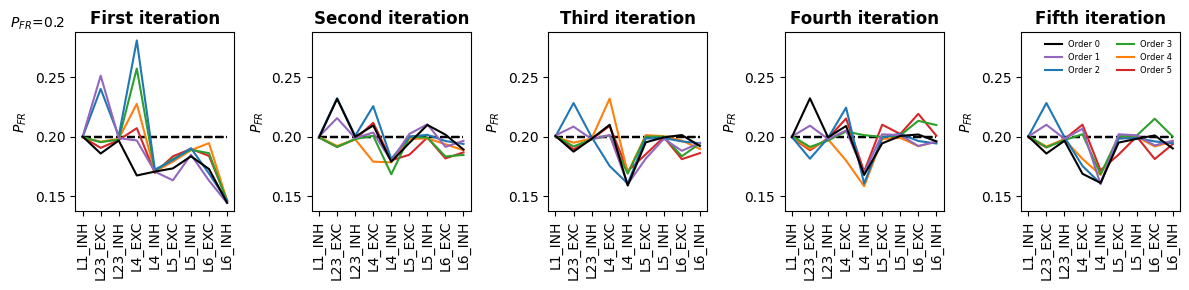

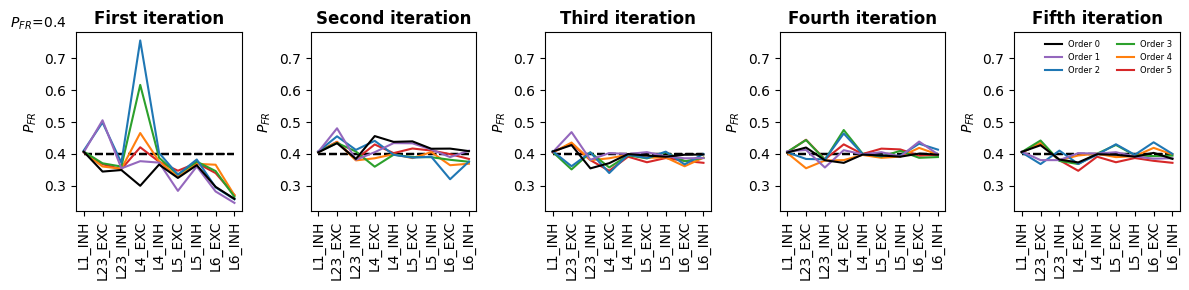

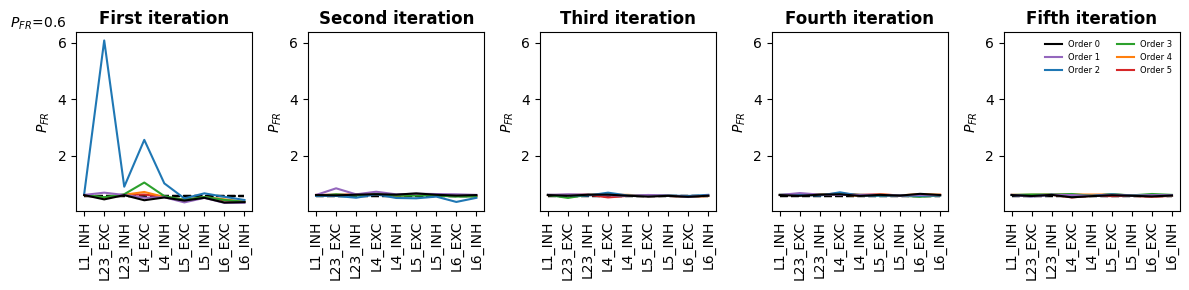

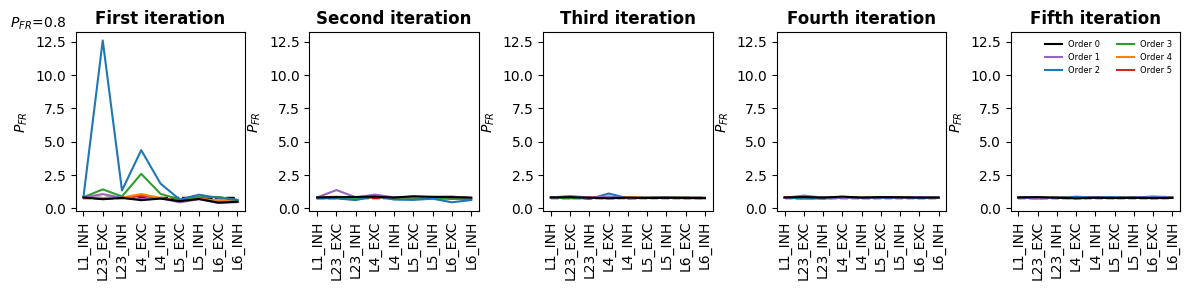

In [193]:
# for pfr_sel in desired_connected_proportion_of_invivo_frs:
for pfr_sel in [0.2, 0.4, 0.6, 0.8]:
    plt.figure(figsize=(12, 3))
    y_lim = None
    for iter_idx in range(num_iter):
        plt.subplot(1, num_iter, iter_idx + 1)
        for _ord, _df in zip(order_list, calib_dfs[pfr_sel][iter_idx]):
            plt.plot(range(len(neuron_classes)), _df['recorded_proportion_of_in_vivo_FR'].values, color=ORDER_COLORS[_ord], label=f'Order {_ord}', zorder=-_ord)
            plt.plot(range(len(neuron_classes)), _df['desired_connected_proportion_of_invivo_frs'], 'k--', zorder=-100)
        P_FR_val = _df["desired_connected_proportion_of_invivo_frs"].unique()[0]
        plt.xticks(range(len(neuron_classes)), neuron_classes, rotation=90)
        plt.ylabel('$P_{FR}$')
        plt.title(f'{upper(ITER_NAMES[iter_idx], 1)} iteration', fontweight='bold')
        if y_lim is None:
            y_lim = plt.ylim()
        else:
            plt.ylim(y_lim)
        if iter_idx == 0:
            plt.text(np.min(plt.xlim()), np.max(plt.ylim()), f'$P_F$$_R$={pfr_sel}   ', ha='right', va='bottom')
    plt.legend(frameon=False, ncols=2, fontsize=6)
    plt.tight_layout()
    plt.show()

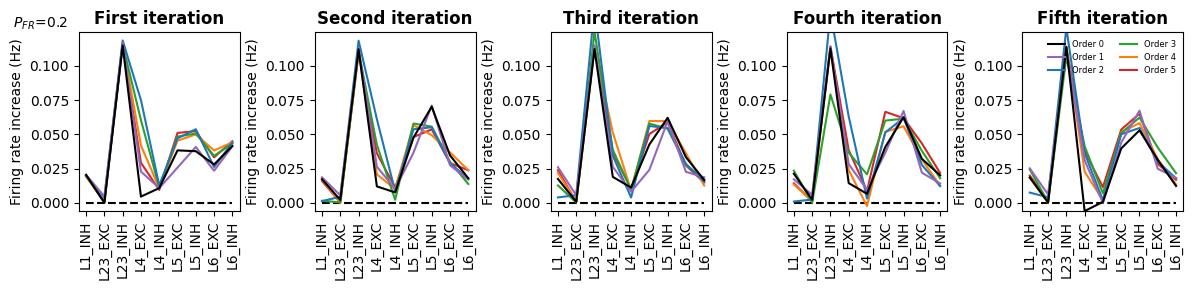

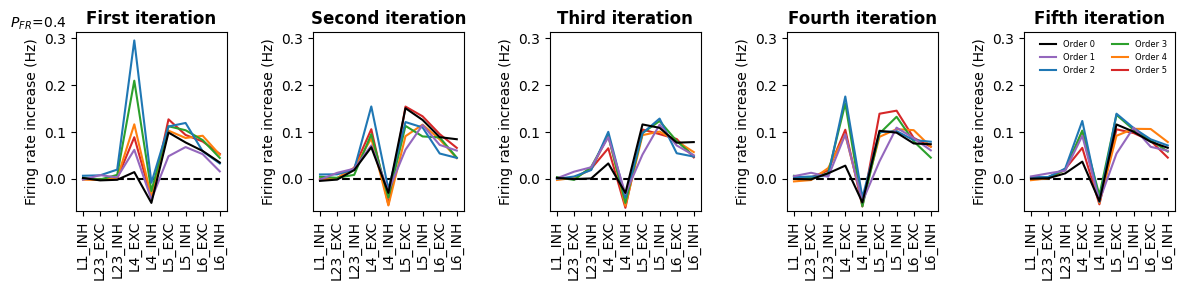

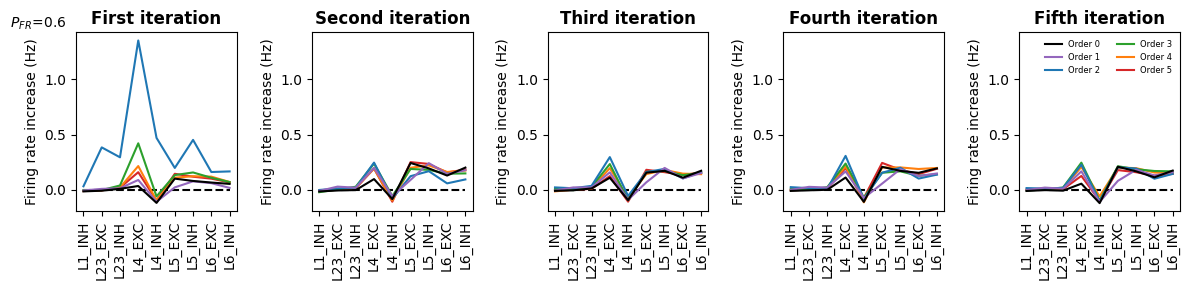

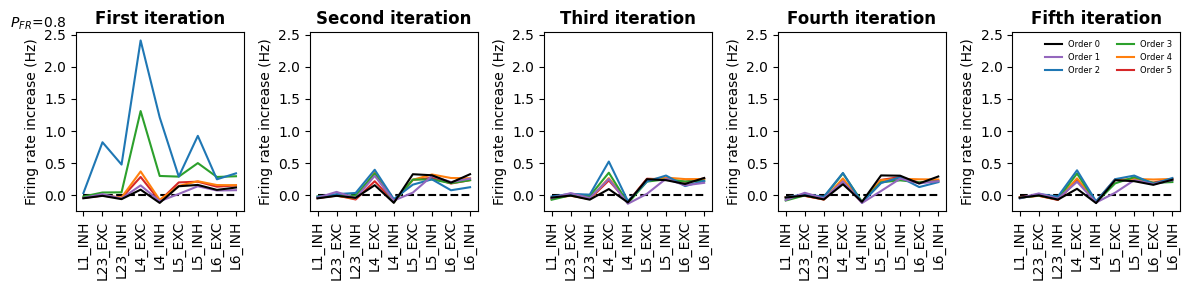

In [195]:
# for pfr_sel in desired_connected_proportion_of_invivo_frs:
for pfr_sel in [0.2, 0.4, 0.6, 0.8]:
    plt.figure(figsize=(12, 3))
    y_lim = None
    for iter_idx in range(num_iter):
        plt.subplot(1, num_iter, iter_idx + 1)
        for _ord, _df in zip(order_list, calib_dfs[pfr_sel][iter_idx]):
            plt.plot(range(len(neuron_classes)), _df['connection_fr_increase'].values, color=ORDER_COLORS[_ord], label=f'Order {_ord}', zorder=-_ord)
        plt.plot(range(len(neuron_classes)), np.zeros(len(neuron_classes)), 'k--', zorder=-100)
        plt.xticks(range(len(neuron_classes)), neuron_classes, rotation=90)
        plt.ylabel('Firing rate increase (Hz)')
        plt.title(f'{upper(ITER_NAMES[iter_idx], 1)} iteration', fontweight='bold')
        if y_lim is None:
            y_lim = plt.ylim()
        else:
            plt.ylim(y_lim)
        if iter_idx == 0:
            plt.text(np.min(plt.xlim()), np.max(plt.ylim()), f'$P_F$$_R$={pfr_sel}   ', ha='right', va='bottom')
    plt.legend(frameon=False, ncols=2, fontsize=6)
    plt.tight_layout()
    plt.show()

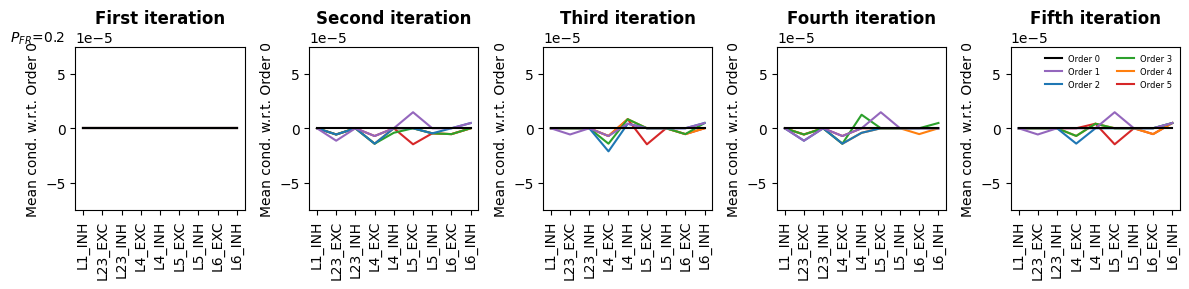

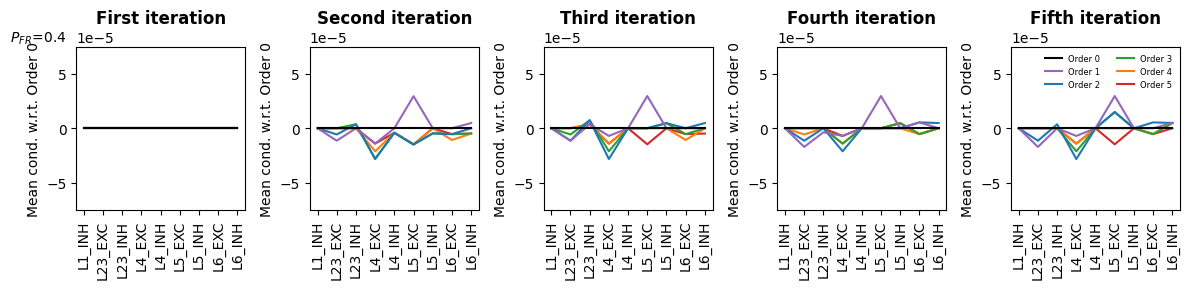

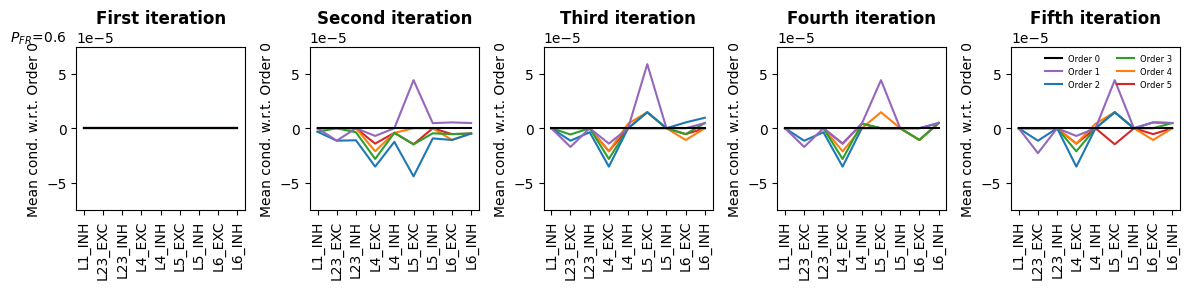

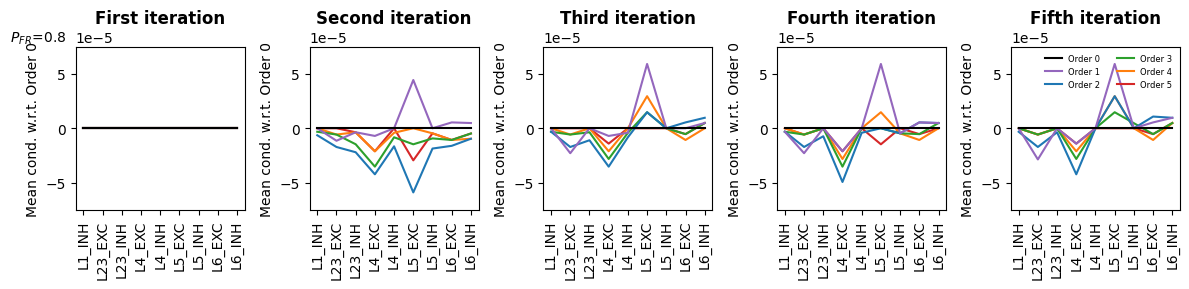

In [213]:
ref_idx = 0  # Original circuit = reference
# for pfr_sel in desired_connected_proportion_of_invivo_frs:
for pfr_sel in [0.2, 0.4, 0.6, 0.8]:
    plt.figure(figsize=(12, 3))
    for iter_idx in range(num_iter):
        ref_df = calib_dfs[pfr_sel][iter_idx][ref_idx]
        plt.subplot(1, num_iter, iter_idx + 1)
        for _ord, _df in zip(order_list, calib_dfs[pfr_sel][iter_idx]):
            plt.plot(range(len(neuron_classes)), _df['true_mean_conductance'].values - ref_df['true_mean_conductance'].values, color=ORDER_COLORS[_ord], label=f'Order {_ord}', zorder=-_ord)
            # plt.plot(range(len(neuron_classes)), (_df['true_mean_conductance'].values - ref_df['true_mean_conductance'].values) / ref_df['true_mean_conductance'].values, color=ORDER_COLORS[_ord], label=f'Order {_ord}', zorder=-_ord)
            # plt.plot(range(len(neuron_classes)), (_df['true_mean_conductance'].values - ref_df['true_mean_conductance'].values) / (_df['true_mean_conductance'].values + ref_df['true_mean_conductance'].values), color=ORDER_COLORS[_ord], label=f'Order {_ord}', zorder=-_ord)
        plt.xticks(range(len(neuron_classes)), neuron_classes, rotation=90)
        plt.ylabel(f'Mean cond. w.r.t. Order {order_list[ref_idx]}')
        plt.title(f'{upper(ITER_NAMES[iter_idx], 1)} iteration', fontweight='bold')
        plt.ylim([-7.5e-5, 7.5e-5])
        # plt.ylim([-0.5, 2.0])
        # plt.ylim([-0.2, 0.6])
        if iter_idx == 0:
            plt.text(np.min(plt.xlim()), np.max(plt.ylim()), f'$P_F$$_R$={pfr_sel}   ', ha='right', va='bottom')
    plt.legend(frameon=False, ncols=2, fontsize=6)
    plt.tight_layout()
    plt.show()

Plotting "Fifth iteration" data:


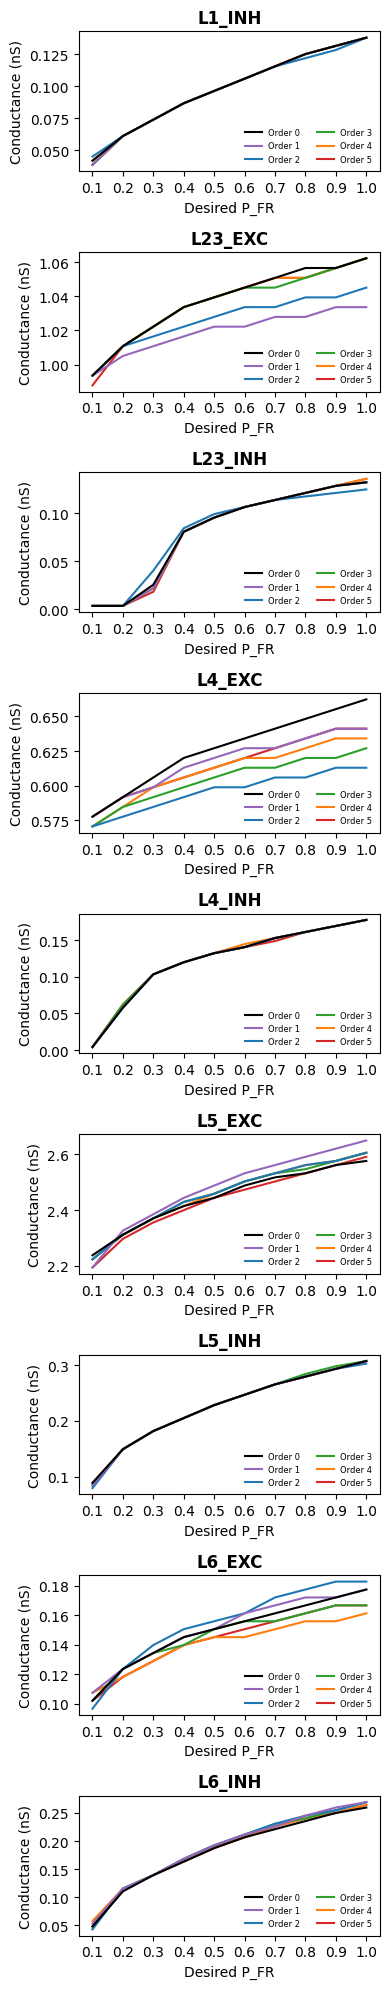

In [248]:
iter_idx = 4 # num_iter - 1  # Last iteration
ref_ord = 0

print(f'Plotting "{upper(ITER_NAMES[iter_idx], 1)} iteration" data:')
plt.figure(figsize=(4, 20))
for nrn_idx, nrn_sel in enumerate(neuron_classes):
    plt.subplot(len(neuron_classes), 1, nrn_idx + 1)
    for _ord in order_list:
        cond = 1e3 * np.array([calib_dfs[pfr_sel][iter_idx][_ord]['true_mean_conductance'].loc[calib_dfs[pfr_sel][iter_idx][_ord]['neuron_class'] == nrn_sel].values[0] for pfr_sel in desired_connected_proportion_of_invivo_frs])
        ref_cond = 1e3 * np.array([calib_dfs[pfr_sel][iter_idx][ref_ord]['true_mean_conductance'].loc[calib_dfs[pfr_sel][iter_idx][ref_ord]['neuron_class'] == nrn_sel].values[0] for pfr_sel in desired_connected_proportion_of_invivo_frs])
        plt.plot(desired_connected_proportion_of_invivo_frs, cond, color=ORDER_COLORS[_ord], label=f'Order {_ord}', zorder=-_ord)
        # plt.plot(desired_connected_proportion_of_invivo_frs, cond - ref_cond, color=ORDER_COLORS[_ord], label=f'Order {_ord}', zorder=-_ord)
        # plt.plot(desired_connected_proportion_of_invivo_frs, (cond - ref_cond) / (cond + ref_cond), color=ORDER_COLORS[_ord], label=f'Order {_ord}', zorder=-_ord)
        # plt.plot(desired_connected_proportion_of_invivo_frs, cond / ref_cond, color=ORDER_COLORS[_ord], label=f'Order {_ord}', zorder=-_ord)
    plt.xticks(desired_connected_proportion_of_invivo_frs)
    plt.xlabel('Desired P_FR')
    plt.ylabel('Conductance (nS)')
    # plt.ylabel('Diff. conductance (nS)')
    plt.title(nrn_sel, fontweight='bold')
    plt.legend(frameon=False, ncols=2, fontsize=6, loc='lower right')
    # plt.ylim([-0.3, 0.3])
plt.tight_layout()
plt.show()

In [242]:
# TODO: Fit function to curves and compare fitting parameter values

In [243]:
# TODO:
# Read rel. conductances from simulation configs (?): "inputs"->"Stimulus gExc_L1"->"mean_percent"
# Conductance vs. firing rates (w/o calib: same conductance, different resulting rates vs. fifth iteration calibration: same rates, different required conductaces)
# Conductance vs. rates curves (per neuron type and/or desired P_FRs)

In [ ]:
# # _iter = 0
# _ord = 0
# _nrn = 'L23_INH'
# [calib_dfs[_iter][_ord]['true_mean_conductance'].loc[calib_dfs[_iter][_ord]['neuron_class'] == _nrn].values[0] for _iter in range(num_iter)]